In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import discreteaction_pendulum
import random
from collections import namedtuple, deque
from matplotlib import pyplot as plt

batch_size = 64
gamma = 0.95
eps_start = 1
eps_end = 0.1

In [2]:
class DQN(nn.Module):

    def __init__(self, n_states, n_actions):
        super().__init__()
        self.layer1 = nn.Linear(n_states, 64)
        self.layer2 = nn.Linear(64, 64)
        self.out = nn.Linear(64,n_actions)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.tanh(self.layer1(x))
        x = F.tanh(self.layer2(x))
        x = self.out(x)
        return x 

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def eps_decay(itr,num_episodes):
    if itr>=num_episodes*100:
        return eps_end
    else:
        return (eps_end - eps_start)*itr/(num_episodes*100) + eps_start

In [4]:
env = discreteaction_pendulum.Pendulum()

In [5]:
n_actions = env.num_actions
n_states = env.num_states

In [6]:
policy_net = DQN(n_states, n_actions)
target_net = DQN(n_states, n_actions)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [7]:
optimizer = optim.RMSprop(policy_net.parameters(), lr=0.00025, alpha=0.95)
memory = ReplayMemory(1000000)

In [8]:
def action(state):
    p = np.random.random()
    if p < eps:
        a = torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)
    else:
        a = policy_net(state).max(1)[1].view(1, 1)
        
    return a

In [13]:
num_episodes = 100

reward_array = np.zeros(num_episodes)

itr = 0

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    s = env.reset()
    s = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    done = False
    time = 0
    while not done:
        eps = eps_decay(itr,num_episodes)
        a = action(s)
        s_next, r, done = env.step(a.item())
        r = torch.tensor([r])
        
        reward_array[i_episode] += gamma**(time)*r
        
        time += 1
        
        s_next = torch.tensor(s_next, dtype=torch.float32).unsqueeze(0)
        

        memory.push(s, a, s_next, r, done)

        # Move to the next state
        s = s_next

        # Perform one step of the optimization (on the policy network)
        update_network()
        
        itr+=1
        
        if itr%1000 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
#         target_net_state_dict = target_net.state_dict()
#         policy_net_state_dict = policy_net.state_dict()
#         for key in policy_net_state_dict:
#             target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
#         target_net.load_state_dict(target_net_state_dict)

10000

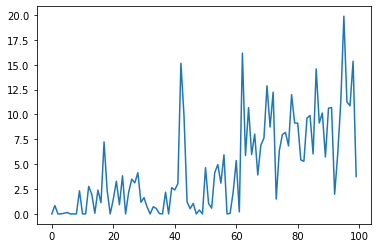

In [14]:
plt.plot(reward_array)
#plt.ylim(0,100)
itr

In [21]:
policy = lambda s: (policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0)).max(1)[1].view(1, 1)).item()

In [22]:
env.video(policy, filename='figures/test_discreteaction_pendulum_1.gif')

MovieWriter imagemagick unavailable; using Pillow instead.


MovieWriter imagemagick unavailable; using Pillow instead.


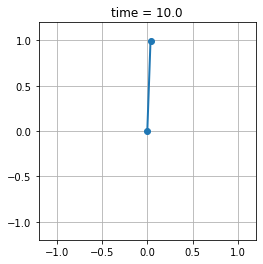

In [15]:
import matplotlib.animation as animation

s = env.reset()
s_traj = [s]
done = False
while not done:
    s = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    (s, r, done) = env.step(policy_net(s).max(1)[1].view(1, 1).item())
    s_traj.append(s)

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
ax.set_aspect('equal')
ax.grid()
line, = ax.plot([], [], 'o-', lw=2)
text = ax.set_title('')

def animate(i):
    theta = s_traj[i][0]
    line.set_data([0, -np.sin(theta)], [0, np.cos(theta)])
    text.set_text(f'time = {i * env.dt:3.1f}')
    return line, text

anim = animation.FuncAnimation(fig, animate, len(s_traj), interval=(1000 * env.dt), blit=True, repeat=False)
anim.save("Pendulum_1.gif", writer='imagemagick', fps=10)

In [16]:
torch.save(policy_net.state_dict(), "latest_good_network_1")

In [10]:
policy_net.load_state_dict(torch.load("latest_good_network"))

<All keys matched successfully>

In [11]:
policy_net

DQN(
  (layer1): Linear(in_features=2, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=31, bias=True)
)

MovieWriter imagemagick unavailable; using Pillow instead.


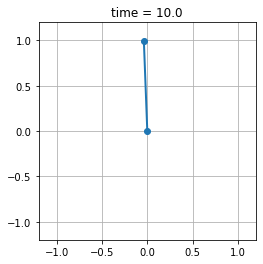

In [12]:
import matplotlib.animation as animation

s = env.reset()
s_traj = [s]
done = False
while not done:
    s = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    (s, r, done) = env.step(policy_net(s).max(1)[1].view(1, 1).item())
    s_traj.append(s)

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
ax.set_aspect('equal')
ax.grid()
line, = ax.plot([], [], 'o-', lw=2)
text = ax.set_title('')

def animate(i):
    theta = s_traj[i][0]
    line.set_data([0, -np.sin(theta)], [0, np.cos(theta)])
    text.set_text(f'time = {i * env.dt:3.1f}')
    return line, text

anim = animation.FuncAnimation(fig, animate, len(s_traj), interval=(1000 * env.dt), blit=True, repeat=False)
anim.save("Pendulum_1.gif", writer='imagemagick', fps=10)